#### Melf Johannsen
#### Cambridge Quantum
### melf.johannsen@cambridgequantum.com

# Developing and executing error-mitigated NISQ algorithms across devices and simulators with $tket$

In [1]:
import warnings
warnings.filterwarnings("ignore")

1) **Quantum Circuit Construction** <br>
2) **Quantum Circuit Compilation** <br>
3) **Quantum Circuit Execution** <br>

# Circuit Construction for QAOA

This example is constructed by considering the algorithm outlined in "A Quantum Approximate Optimisation Algorithim" by Gutmann, Farhi and Goldstone, arxiv:1411.4028. <br>

$\left|\psi(\beta,\gamma)\right\rangle = e^{-i\beta B}e^{-i\gamma H} ... \left|+\right\rangle$

An example max-cut problem:

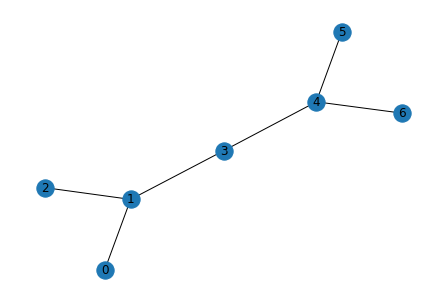

In [2]:
import networkx as nx
max_cut_graph_edges = [(0,1), (1,2), (1,3), (3,4), (4,5), (4,6)]
n_nodes = 7

max_cut_graph = nx.Graph()
max_cut_graph.add_edges_from(max_cut_graph_edges)
nx.draw(max_cut_graph, labels={node: node for node in max_cut_graph.nodes()})

expected_results = [(0,1,0,0,1,0,0), (1,0,1,1,0,1,1)]

## Define Cost Hamiltonian: $\gamma H$

In [3]:
from typing import List, Tuple, Any
from pytket.utils import QubitPauliOperator
from pytket.pauli import QubitPauliString, Pauli
from pytket import Qubit

def qaoa_graph_to_cost_hamiltonian(edges: List[Tuple[int, int]], cost_angle: float) -> QubitPauliOperator:
    qpo_dict = {QubitPauliString(): len(edges)*0.5*cost_angle}
    for e in edges:
        term_string = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.Z, Pauli.Z])
        qpo_dict[term_string] = -0.5*cost_angle
    return QubitPauliOperator(qpo_dict)

cost_angle = 1.0
cost_ham_qpo = qaoa_graph_to_cost_hamiltonian(max_cut_graph_edges, cost_angle)
print(cost_ham_qpo)

{(): 3.00000000000000, (Zq[0], Zq[1]): -0.500000000000000, (Zq[1], Zq[2]): -0.500000000000000, (Zq[1], Zq[3]): -0.500000000000000, (Zq[3], Zq[4]): -0.500000000000000, (Zq[4], Zq[5]): -0.500000000000000, (Zq[4], Zq[6]): -0.500000000000000}


## Hamiltonian Circuit

In [4]:
from pytket.utils import gen_term_sequence_circuit
from pytket import Circuit
from pytket.circuit import display

cost_ham_circuit = gen_term_sequence_circuit(cost_ham_qpo, Circuit(n_nodes))
display.render_circuit_jupyter(cost_ham_circuit)

Phase,Paulis
-0.5,Pauli.Z Pauli.Z
Phase,Paulis
-0.5,Pauli.Z Pauli.Z
Phase,Paulis
-0.5,Pauli.Z Pauli.Z
Phase,Paulis
-0.5,Pauli.Z Pauli.Z
Phase,Paulis
-0.5,Pauli.Z Pauli.Z
Phase,Paulis


In [5]:
from pytket.transform import Transform

Transform.DecomposeBoxes().apply(cost_ham_circuit)
display.render_circuit_jupyter(cost_ham_circuit)

## Construction of the Mixer Hamiltonian: $\beta B$

In [6]:
mixer_angle = 0.8
mixer_ham_qpo =  QubitPauliOperator({QubitPauliString([Qubit(i)], [Pauli.X]): mixer_angle for i in range(n_nodes)})
mixer_ham_circuit = gen_term_sequence_circuit(mixer_ham_qpo, Circuit(n_nodes))
Transform.DecomposeBoxes().apply(mixer_ham_circuit)
display.render_circuit_jupyter(mixer_ham_circuit)

## Define the Initial State

In [7]:
def qaoa_initial_circuit(n_qubits: int) -> Circuit:
    c = Circuit(n_qubits)
    for i in range(n_qubits):
        c.H(i)
    return c

superposition_circuit = qaoa_initial_circuit(n_nodes)

display.render_circuit_jupyter(superposition_circuit)

## Construct QAOA Circuit

In [8]:
def qaoa_max_cut_circuit(edges: List[Tuple[int, int]],
                         n_nodes: int,
                         mixer_angles: List[float],
                         cost_angles: List[float]) -> Circuit:
    
    assert len(mixer_angles) == len(cost_angles)
    
    # initial state
    qaoa_circuit = qaoa_initial_circuit(n_nodes)
    
    # add cost and mixer terms to state
    for cost, mixer in zip(cost_angles, mixer_angles):
        cost_ham = qaoa_graph_to_cost_hamiltonian(edges, cost)
        mixer_ham = QubitPauliOperator({QubitPauliString([Qubit(i)], [Pauli.X]): mixer for i in range(n_nodes)})
        qaoa_circuit.append(gen_term_sequence_circuit(cost_ham, Circuit(n_nodes)))
        qaoa_circuit.append(gen_term_sequence_circuit(mixer_ham, Circuit(n_nodes)))
        
    Transform.DecomposeBoxes().apply(qaoa_circuit)
    return qaoa_circuit

## Measurement to the Circuit

In [9]:
from pytket.circuit import Bit

def qaoa_gen_all_measurement_circuit(ham: QubitPauliOperator,
                                     my_prep_curcuit: Circuit):

    all_measurement_circuit = []

    for qps, cof in ham._dict.items():    
        measurement_circuit = Circuit()
        measured_qbs = []
        for qb, p in qps.map.items():
            if p == Pauli.I:
                continue
            measured_qbs.append(qb)
            measurement_circuit.add_qubit(qb)
            if p == Pauli.X: # unused in our case
                measurement_circuit.H(qb)
            elif p == Pauli.Y: # unused in our case
                measurement_circuit.Rx(0.5, qb)
        bits = []
        for b_idx, qb in enumerate(measured_qbs):
            unit = Bit(b_idx)
            bits.append(unit)
            measurement_circuit.add_bit(unit, False)
            measurement_circuit.Measure(qb, unit)

        c = my_prep_curcuit.copy()
        c.append(measurement_circuit)
        all_measurement_circuit.append((c, (qps, bits)))    
    
    return all_measurement_circuit

## Calculate the Energy of the Results

In [10]:
from pytket.backends.backendresult import BackendResult

def qaoa_estimated_energy(results: BackendResult,
                          all_measurement_circuit: List[Tuple[Circuit, Tuple[Any, int]]],
                          ham: QubitPauliOperator):

    organised_results = {}

    for r, c in zip(results, all_measurement_circuit):
        bits=c[1][1]
        counts = r.get_counts(cbits=bits)
        expectations = expectation_from_counts(counts)
        # c[1][0] is the qubit pauli string
        organised_results[c[1][0]] = expectations
    
    # calculate expectation of hamiltonian observable:
    estimated_energy = 0

    for qps, coef in ham._dict.items():
        expect = organised_results[qps]
        estimate = expect * coef
        estimated_energy += estimate
    
    return estimated_energy

## Set up QAOA Instance

In [11]:
from pytket.backends import Backend
from pytket.passes import BasePass
import numpy as np
from pytket.utils import expectation_from_counts

def qaoa_instance(backend: Backend,
                  compiler_pass: BasePass,
                  guess_mixer_angles: np.array,
                  guess_cost_angles: np.array,
                  shots: int = 5000) -> float:

    assert len(guess_mixer_angles) == len(guess_cost_angles)
    
    # step 1: get state guess
    my_prep_circuit = qaoa_max_cut_circuit(max_cut_graph_edges,
                                           n_nodes,
                                           guess_mixer_angles,
                                           guess_cost_angles)
    
    # step 2: get problem hamiltonian
    ham = qaoa_graph_to_cost_hamiltonian(max_cut_graph_edges, 1.0)
    
    # step 3: prepare measurement circuit
    all_measurement_circuit = qaoa_gen_all_measurement_circuit(ham, my_prep_circuit)
        
    # step 4: compile the circuit for the backend
    for c in all_measurement_circuit:
        compiler_pass(c[0])

    # step 5: run measurement circuit on backend   
    handles = backend.process_circuits([c[0] for c in all_measurement_circuit], shots)
    
    # step 6: get expectations
    results = backend.get_results(handles)
    estimated_energy = qaoa_estimated_energy(results, all_measurement_circuit, ham)
        
    return estimated_energy

## Optimise Energy by Guessing Parameters

In [12]:
def qaoa_optimise_energy(compiler_pass: BasePass,
                         backend: Backend,
                         iterations: int = 100,
                         n: int = 3,
                         shots: int = 5000):
    
    highest_energy = 0    
    best_guess_mixer_angles = [0 for i in range(n)]    
    best_guess_cost_angles = [0 for i in range(n)]
    
    # guess some angles (iterations)-times and try if they are better than the best angles found before
    
    for i in range(iterations):
        
        guess_mixer_angles = np.random.uniform(0, 1, n)
        guess_cost_angles = np.random.uniform(0, 1, n)
        
        qaoa_energy = qaoa_instance(backend,
                                    compiler_pass,
                                    guess_mixer_angles,
                                    guess_cost_angles,
                                    shots)
        
        if(qaoa_energy > highest_energy):
            
            print("new highest energy found: ", qaoa_energy)
            
            best_guess_mixer_angles = guess_mixer_angles
            best_guess_cost_angles = guess_cost_angles
            highest_energy = qaoa_energy
            
    print("highest energy: ", highest_energy)
    print("best guess mixer angles: ", best_guess_mixer_angles)
    print("best guess cost angles: ", best_guess_cost_angles)
    return best_guess_mixer_angles, best_guess_cost_angles

## Calculate the State for the final Parameters

In [13]:
import qaoaplotfunctions as qaoaplot

def qaoa_calculate(backend: Backend,
                   compiler_pass: BasePass,
                   shots: int = 5000,
                   iterations: int = 100) -> float:
    
    # find the parameters for the highest energy
    best_mixer, best_cost = qaoa_optimise_energy(compiler_pass,
                                                 backend,
                                                 iterations,
                                                 3,
                                                 shots)
    
    # get the circuit with the final parameters of the optimisation:
    my_qaoa_circuit = qaoa_max_cut_circuit(max_cut_graph_edges,
                                           n_nodes,
                                           best_mixer,
                                           best_cost)

    my_qaoa_circuit.measure_all()

    compiler_pass(my_qaoa_circuit)
    handle = backend.process_circuit(my_qaoa_circuit, shots)

    result = backend.get_result(handle)    

    qaoaplot.plotresults(result, expected_results)

## Results with the Noiseless Simulator

In [14]:
from pytket.extensions.qiskit import AerBackend

backend = AerBackend()
comp = backend.compile_circuit

new highest energy found:  2.96100000000000
new highest energy found:  4.08000000000000
new highest energy found:  4.21740000000000
new highest energy found:  4.73260000000000
new highest energy found:  4.79240000000000
highest energy:  4.79240000000000
best guess mixer angles:  [0.36543495 0.10402607 0.02883453]
best guess cost angles:  [0.38476725 0.50749646 0.2403255 ]


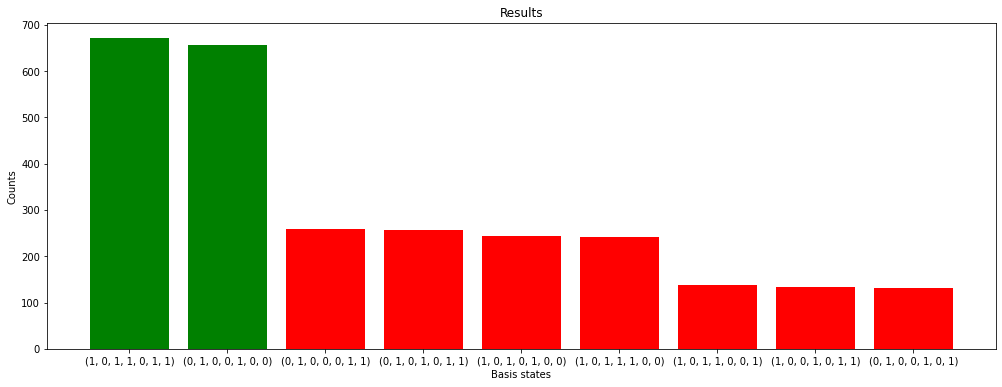

In [15]:
qaoa_calculate(backend, comp, shots = 5000, iterations = 100)

## Results with the Noisy Simulator

In [16]:
from pytket.extensions.qiskit import IBMQEmulatorBackend

backend = IBMQEmulatorBackend('ibmq_guadalupe', hub='partner-cqc', group='internal', project='default')
comp = backend.compile_circuit

new highest energy found:  2.73600000000000
new highest energy found:  2.95740000000000
new highest energy found:  3.01260000000000
new highest energy found:  3.16620000000000
new highest energy found:  3.44320000000000
new highest energy found:  3.54580000000000
new highest energy found:  3.66040000000000
highest energy:  3.66040000000000
best guess mixer angles:  [0.39364283 0.15429965 0.14405957]
best guess cost angles:  [0.41308986 0.49709969 0.62157138]


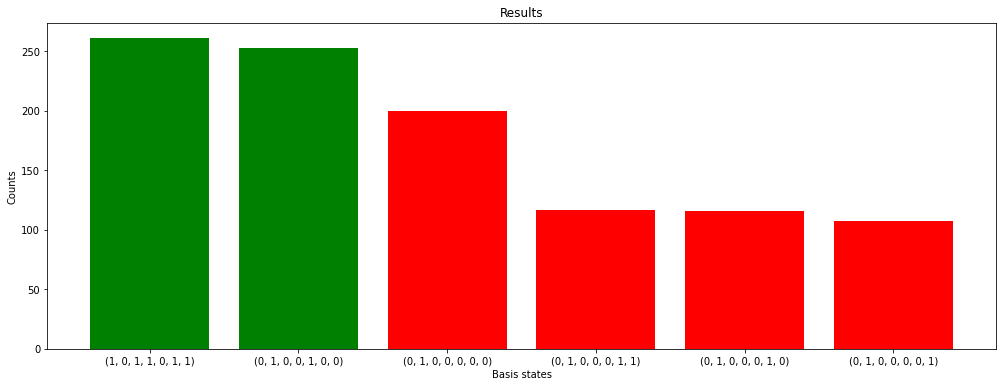

In [17]:
qaoa_calculate(backend, comp, shots = 5000, iterations = 100)

## Circuit of one QAOA Instance with one Mixer and one Cost Angle

In [18]:
my_qaoa_circuit = qaoa_max_cut_circuit(max_cut_graph_edges, n_nodes, [0.8], [1.0])
display.render_circuit_jupyter(my_qaoa_circuit)

In [19]:
from pytket.circuit import OpType

print("Number of gates in Circuit: ", my_qaoa_circuit.n_gates)
print("Number of CX gates in Circuit: ", my_qaoa_circuit.n_gates_of_type(OpType.CX))

Number of gates in Circuit:  46
Number of CX gates in Circuit:  12


## Compile Circuit for Device

In [20]:
guadalupe_backend = IBMQEmulatorBackend('ibmq_guadalupe', hub='partner-cqc', group='internal', project='default')
my_qaoa_circuit = qaoa_max_cut_circuit(max_cut_graph_edges, n_nodes, [0.8], [1.0])
guadalupe_backend.compile_circuit(my_qaoa_circuit)
print("Number of gates in circuit: ", my_qaoa_circuit.n_gates)
print("Number of CX gates in circuit: ", my_qaoa_circuit.n_gates_of_type(OpType.CX))
display.render_circuit_jupyter(my_qaoa_circuit)

Number of gates in circuit:  77
Number of CX gates in circuit:  15


In [21]:
from pytket.passes import OptimisePhaseGadgets

my_qaoa_circuit = qaoa_max_cut_circuit(max_cut_graph_edges, n_nodes, [0.8], [1.0])
OptimisePhaseGadgets().apply(my_qaoa_circuit)
print("Number of gates in Circuit: ", my_qaoa_circuit.n_gates)
print("Number of CX gates in Circuit: ", my_qaoa_circuit.n_gates_of_type(OpType.CX))
display.render_circuit_jupyter(my_qaoa_circuit)

Number of gates in Circuit:  32
Number of CX gates in Circuit:  12


In [22]:
from pytket.routing import NoiseAwarePlacement

guadalupe_info = guadalupe_backend.backend_info
guadalupe_placer = NoiseAwarePlacement(arc=guadalupe_info.architecture,
                                       node_errors=guadalupe_info.averaged_node_gate_errors,
                                       link_errors=guadalupe_info.averaged_edge_gate_errors,
                                       readout_errors=guadalupe_info.averaged_readout_errors)

my_qaoa_circuit = qaoa_max_cut_circuit(max_cut_graph_edges, n_nodes, [0.8], [1.0])

print(guadalupe_placer.get_placement_map(my_qaoa_circuit))
guadalupe_placer.modify_config(depth_limit = 100, max_matches = 20000)
print(guadalupe_placer.get_placement_map(my_qaoa_circuit))

{q[0]: node[11], q[1]: node[8], q[2]: node[9], q[3]: node[5]}
{q[0]: node[15], q[1]: node[12], q[2]: node[13], q[3]: node[10], q[4]: node[7], q[5]: node[6], q[6]: node[4]}


In [23]:
from pytket.passes import CXMappingPass

my_qaoa_circuit = qaoa_max_cut_circuit(max_cut_graph_edges, n_nodes, [0.8], [1.0])

guadalupe_mapping_pass = CXMappingPass(
    guadalupe_info.architecture,
    guadalupe_placer,
    directed_cx=False
)
guadalupe_mapping_pass.apply(my_qaoa_circuit)
print("Number of gates in Circuit: ", my_qaoa_circuit.n_gates)
print("Number of CX gates in Circuit: ", my_qaoa_circuit.n_gates_of_type(OpType.CX))

display.render_circuit_jupyter(my_qaoa_circuit)

Number of gates in Circuit:  46
Number of CX gates in Circuit:  12


# Predicates

In [24]:
from pytket.predicates import GateSetPredicate, NoMidMeasurePredicate, ConnectivityPredicate

my_qaoa_circuit = qaoa_max_cut_circuit(max_cut_graph_edges, n_nodes, [0.8], [1.0])

ibm_gateset = GateSetPredicate({OpType.X, OpType.SX, OpType.Rz, OpType.CX, OpType.Measure})

print("check ibm gateset predicate: ", ibm_gateset.verify(my_qaoa_circuit))

midmeasure = NoMidMeasurePredicate()

print("check mid measure predicate: ", midmeasure.verify(my_qaoa_circuit))

ibm_conn_predicate = ConnectivityPredicate(guadalupe_info.architecture)

print("check ibm connectivity predicate predicate: ", ibm_conn_predicate.verify(my_qaoa_circuit))

check ibm gateset predicate:  False
check mid measure predicate:  True
check ibm connectivity predicate predicate:  False


In [25]:
from pytket.passes import RebaseCustom
from pytket.extensions.qiskit.backends.ibm import _tk1_to_x_sx_rz

ibm_rebase = RebaseCustom(
    {OpType.CX},
    Circuit(2).CX(0, 1),
    {OpType.X, OpType.SX, OpType.Rz},
    _tk1_to_x_sx_rz,
)
ibm_rebase.apply(my_qaoa_circuit)

print("check ibm gateset predicate: ", ibm_gateset.verify(my_qaoa_circuit))

print("Number of gates in Circuit: ", my_qaoa_circuit.n_gates)
print("Number of CX gates in Circuit: ", my_qaoa_circuit.n_gates_of_type(OpType.CX))

check ibm gateset predicate:  True
Number of gates in Circuit:  88
Number of CX gates in Circuit:  12


## Local Gate Optimisation

In [26]:
from pytket.passes import FullPeepholeOptimise

my_qaoa_circuit = qaoa_max_cut_circuit(max_cut_graph_edges, n_nodes, [0.8], [1.0])


FullPeepholeOptimise().apply(my_qaoa_circuit)
print("Number of gates in Circuit: ", my_qaoa_circuit.n_gates)
print("Number of CX gates in Circuit: ", my_qaoa_circuit.n_gates_of_type(OpType.CX))

Number of gates in Circuit:  23
Number of CX gates in Circuit:  6


## Sequence Pass

In [27]:
from pytket.passes import SequencePass, RemoveRedundancies

sequence_pass = SequencePass([OptimisePhaseGadgets(),
                              FullPeepholeOptimise(),
                              guadalupe_mapping_pass,
                              FullPeepholeOptimise(allow_swaps=False),
                              ibm_rebase, RemoveRedundancies()])

my_qaoa_circuit = qaoa_max_cut_circuit(max_cut_graph_edges, n_nodes, [0.8], [1.0])
sequence_pass.apply(my_qaoa_circuit)
print("Number of gates in circuit: ", my_qaoa_circuit.n_gates)
print("Number of CX gates in circuit: ", my_qaoa_circuit.n_gates_of_type(OpType.CX))

Number of gates in circuit:  64
Number of CX gates in circuit:  6


## Compilation Units

In [28]:
from pytket.predicates import CompilationUnit

my_qaoa_circuit = qaoa_max_cut_circuit(max_cut_graph_edges, n_nodes, [0.8], [1.0])


cu = CompilationUnit(my_qaoa_circuit, [ibm_gateset, midmeasure, ibm_conn_predicate])

print(cu.check_all_predicates())

sequence_pass.apply(cu)

print(cu.check_all_predicates())

print("Number of gates in circuit: ", my_qaoa_circuit.n_gates)
print("Number of CX gates in circuit: ", my_qaoa_circuit.n_gates_of_type(OpType.CX))

False
True
Number of gates in circuit:  46
Number of CX gates in circuit:  12


new highest energy found:  3.36840000000000
new highest energy found:  3.53200000000000
new highest energy found:  3.74140000000000
new highest energy found:  4.04140000000000
new highest energy found:  4.10900000000000
highest energy:  4.10900000000000
best guess mixer angles:  [0.46446132 0.38375263 0.21737721]
best guess cost angles:  [0.40545933 0.95524469 0.69684183]


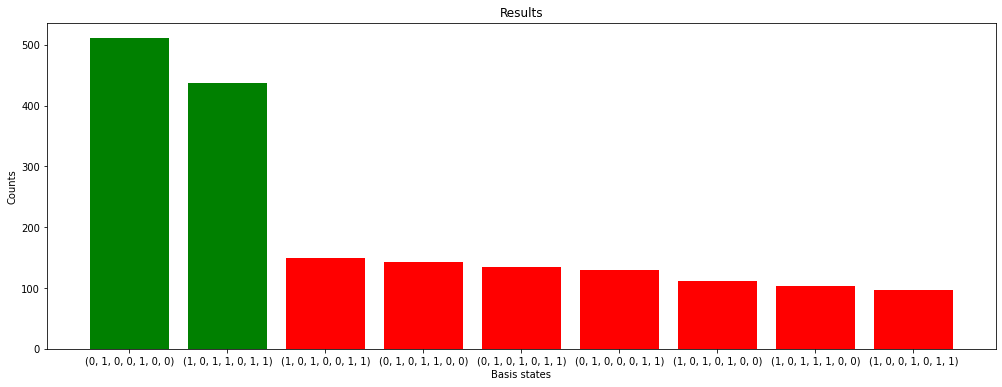

In [29]:
backend = IBMQEmulatorBackend('ibmq_guadalupe', hub='partner-cqc', group='internal', project='default')
comp = sequence_pass.apply
qaoa_calculate(backend, comp, shots = 5000, iterations = 100)

# How to Avoid Long Compilation Time

In [30]:
from sympy import symbols
from pytket.predicates import NoSymbolsPredicate

a, b = symbols("a b")
circ_symbolic = Circuit(2)
circ_symbolic.Ry(a, 0)
circ_symbolic.Ry(a, 1)
circ_symbolic.CX(0, 1)
circ_symbolic.Rz(b, 1)
circ_symbolic.CX(0, 1)

backend = AerBackend()

# compile once
circ_symbolic = backend.get_compiled_circuit(circ_symbolic)   

print(NoSymbolsPredicate().verify(circ_symbolic))

circ_runable = circ_symbolic.copy()
circ_runable.symbol_substitution({a : 0.1, b : 0.2})
    
print(NoSymbolsPredicate().verify(circ_runable))

# no need to compile again
handle = backend.process_circuit(circ_runable, 5000)

False
True


## Define Symbolic Parameters using Sympy

In [31]:
a_s = symbols("a")
b_s = symbols("b")
c_s = symbols("c")
d_s = symbols("d")
e_s = symbols("e")
f_s = symbols("f")

In [32]:
def qaoa_sym_all_measurement_circuit(compiler_pass: BasePass) -> List[Tuple[Circuit, Tuple[Any, int]]]:

    # define the circuit
    my_prep_curcuit = qaoa_max_cut_circuit(max_cut_graph_edges,
                                               n_nodes,
                                               [a_s, b_s, c_s],
                                               [d_s, e_s, f_s])
    
    # get hamiltonian
    ham = qaoa_graph_to_cost_hamiltonian(max_cut_graph_edges, 1.0)
    
    # prepare meturement circuit
    all_measurement_circuit = []

    for qps, cof in ham._dict.items():
        measurement_circuit = Circuit()
        measured_qbs = []
        for qb, p in qps.map.items():
            if p == Pauli.I:
                continue
            measured_qbs.append(qb)
            measurement_circuit.add_qubit(qb)
            if p == Pauli.X:
                measurement_circuit.H(qb)
            elif p == Pauli.Y:
                measurement_circuit.Rx(0.5, qb)
        bits = []
        for b_idx, qb in enumerate(measured_qbs):
            unit = Bit(b_idx)
            bits.append(unit)
            measurement_circuit.add_bit(unit, False)
            measurement_circuit.Measure(qb, unit)

        c = my_prep_curcuit.copy()
        c.append(measurement_circuit)
        all_measurement_circuit.append([c, (qps, bits)])
        
    # compile circuit for backend
    for c in all_measurement_circuit:
        compiler_pass(c[0])
    
    return all_measurement_circuit

In [33]:
def qaoa_sym_instance(backend: Backend,
                      all_measurement_circuit: List[Tuple[Circuit, Tuple[Any, int]]],
                      guess_mixer_angles: np.array,
                      guess_cost_angles: np.array,
                      shots: int = 5000) -> float:

    assert len(guess_mixer_angles) == len(guess_cost_angles)
    assert len(guess_mixer_angles) == 3
    
    ham = qaoa_graph_to_cost_hamiltonian(max_cut_graph_edges, 1.0)
    
    all_measurement_circuit_subs = []
                                                    
    for ci in all_measurement_circuit:
        circ = ci[0].copy()
        circ.symbol_substitution({a_s : guess_mixer_angles[0],
                                  b_s : guess_mixer_angles[1],
                                  c_s : guess_mixer_angles[2],
                                  d_s : guess_cost_angles[0],
                                  e_s : guess_cost_angles[1],
                                  f_s : guess_cost_angles[2]})
        all_measurement_circuit_subs.append((circ, ci[1]))

    handles = backend.process_circuits([c[0] for c in all_measurement_circuit_subs], shots)
    
    # get expectations
    results = backend.get_results(handles)

    organised_results = {}

    for r, c in zip(results, all_measurement_circuit_subs):
        bits=c[1][1]
        counts = r.get_counts(cbits=bits)
        expectations = expectation_from_counts(counts)
        organised_results[c[1][0]] = expectations
    
    # calculate expectation of hamiltonian observable
    estimated_energy = 0
    for qps, coef in ham._dict.items():
        expect = organised_results[qps]
        estimate = expect * coef
        estimated_energy += estimate    
        
    return estimated_energy

In [34]:
def qaoa_sym_optimise_energy(backend: Backend,
                             compiler_pass: BasePass,
                             shots: int = 5000,
                             iterations: int = 100) -> Tuple[List[float], List[float]]:
    # find the parameters for the highest energy
    highest_energy = 0
    n = 3

    best_guess_mixer_angles = [0 for i in range(n)]
    best_guess_cost_angles = [0 for i in range(n)]

    # guess some angles (iterations)-times and try if they are better than the best angles found before    
    all_measurement_circuit = qaoa_sym_all_measurement_circuit(compiler_pass)    
    
    for i in range(iterations):
        
        guess_mixer_angles = np.random.uniform(0, 1, n)
        guess_cost_angles = np.random.uniform(0, 1, n)
        
        qaoa_energy = qaoa_sym_instance(backend,
                                        all_measurement_circuit,
                                        guess_mixer_angles,
                                        guess_cost_angles,
                                        shots)
        
        if(qaoa_energy > highest_energy):
            print("new highest energy found: ", qaoa_energy)
            best_guess_mixer_angles = guess_mixer_angles
            best_guess_cost_angles = guess_cost_angles
            highest_energy = qaoa_energy
            
    print("highest energy: ", highest_energy)
    print("best guess mixer angles: ", best_guess_mixer_angles)
    print("best guess cost angles: ", best_guess_cost_angles)
    
    return best_guess_mixer_angles, best_guess_cost_angles

In [35]:
def qaoa_sym_calculate(backend: Backend,
                       compiler_pass: BasePass,
                       shots: int = 5000,
                       iterations: int = 100) -> float:
    
    best_mixer, best_cost = qaoa_sym_optimise_energy(backend, compiler_pass, shots, iterations)
    
    # calculate the result of the optimisation:
    my_qaoa_circuit = qaoa_max_cut_circuit(max_cut_graph_edges,
                                           n_nodes,
                                           best_mixer,
                                           best_cost)
    my_qaoa_circuit.measure_all()
    compiler_pass(my_qaoa_circuit)    
    handle = backend.process_circuit(my_qaoa_circuit, shots)
    result = backend.get_result(handle)
    qaoaplot.plotresults(result, expected_results)

new highest energy found:  2.34480000000000
new highest energy found:  3.01880000000000
new highest energy found:  3.04300000000000
new highest energy found:  3.84420000000000
new highest energy found:  3.91300000000000
new highest energy found:  4.25380000000000
highest energy:  4.25380000000000
best guess mixer angles:  [0.16008575 0.24199322 0.12600171]
best guess cost angles:  [0.21562118 0.74933329 0.7536967 ]


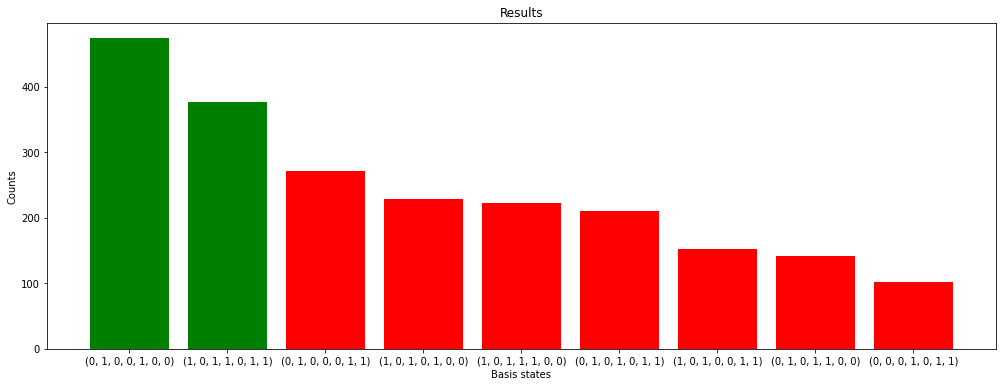

In [36]:
backend = IBMQEmulatorBackend('ibmq_guadalupe', hub='partner-cqc', group='internal', project='default')
comp = sequence_pass.apply
qaoa_sym_calculate(backend, comp, shots = 5000, iterations = 100)

# Developing and executing error-mitigated NISQ algorithms across devices and simulators with $tket$ - what have we covered? 

## 1) Circuit Construction 
Helper methods for generating quantum circuits from Hamiltonians <br>
Defining functions for generating circuits to some specification <br>

## 2) Circuit Compilation 
Using Transform and Optimisation Passes to improve Circuit Compilation <br>
Changing configuration of passes i.e. NoiseAwarePlacement configuration <br>
Combining Passes into a Sequence Pass <br>
Symbolic compilation <br>